# Hierarchical Sensor Model</br><small>Localization with an idealized map</small>

- Putting priors on sensor parameters
- Inferring position from noisy observations and with an idealized map

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import bayes3d as b3d
import genjax
from genjax import gen, choice_map, vector_choice_map
import jax
from jax import jit, vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from genjax._src.core.transforms.incremental import UnknownChange, NoChange, Diff
import trimesh
from functools import partial

key = jax.random.PRNGKey(0)
console = genjax.pretty(show_locals=False)

## Making a render function (closed over the map)

In [3]:
from xsight.utils import *
from xsight.importance import _importance_sampling, _update, _generate, _simulate, _propose
from xsight.pose import pack_pose, unpack_pose, apply_pose, from_euler, CAM_ALONG_X
from xsight.meshes import *
from xsight.plotting import *

# Load environment data
fname = "./data/test_env_2d.json"
_segs, _boxes, _xs, _hds, _dxs, _dhds = unpack_2d_env_data(fname)
_verts  = _segs.reshape(-1,2)
_center = np.min(_verts, axis=0) + np.max(_verts, axis=0)/2
_T      = len(_xs)
_segs   = _segs.reshape(-1,2,2)
_boxes  = _boxes.reshape(-1,2,2)
_bb     = bounding_box(_segs)
_ps     = np.concatenate([_xs, _hds[:,None]], axis=1)

_T

50

In [4]:
# Create a 3d mesh from the 2d data and 
# create a scene for the renderer
box_mesh = trimesh.util.concatenate([trimesh_from_2d_segs(box) for box in _boxes.reshape(-1,4,4)])
map_mesh = trimesh_from_2d_segs(_segs.reshape(-1,4))
table = create_cuboid(20, 20, -0.1)
table = move_to_xy(table, *_center)
map_mesh.vertices[:,2] -= 0.5
box_mesh.vertices[:,2] -= 0.5
table.vertices[:,2]    -= 0.5

In [5]:
# Set up the renderer and 
# add the scene mesh (or map mesh)
def make_render_function(meshes, w=100,h=1, fx=30, fy =30):
    """
    Create a render function from a list of meshes 
    (and camera intrinsics).
    """
    intrinsics = b3d.Intrinsics(
        width = w, height = h,
        fx=fx, fy=fy,
        cx=w/2 - 0.5, cy=h/2 - 0.5,
        near=0.01, far=10.0
    )
    b3d.setup_renderer(intrinsics)
    for mesh in meshes:
        b3d.RENDERER.add_mesh(mesh, center_mesh=False)


    def render(p, inds=[0,1]):
        """Render an image from a fixed scene that this is closed over"""
        p_ = b3d.t3d.inverse_pose(p)
        X  = b3d.RENDERER.render(jnp.tile(p_, (len(inds),1,1)), jnp.array(inds))
        return X;

    return render


render = make_render_function([map_mesh, box_mesh, table])

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 32, 1024)


In [6]:
def lift_pose(v, z=0.0, pitch=0.0, roll=0.0):
    """Lifts a 2d pose veoctor (x1,x2,hd) to 3d"""
    x  = v[:2]
    hd = v[2]
    return pack_pose(
        jnp.concatenate([x, jnp.array([z])]),
        from_euler(hd) @ CAM_ALONG_X
    ) 

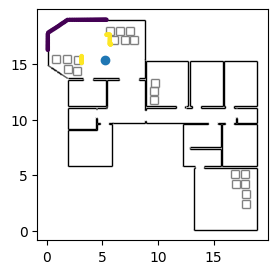

In [94]:
t  = 40
p  = _ps[t]
X  = render(lift_pose(p), inds=[0,1])
xs = X[0][:,[0,2]]
xs = apply_2dpose(p, xs)


# ===========================
plt.figure(figsize=(3,3))
plt.gca().set_aspect(1)
plot_segs(_segs, c="k", zorder=-1)
plot_segs(_boxes, c="gray", zorder=-1)
plt.scatter(*_ps[t][:2], marker="o")
plt.scatter(*xs.T,c=X[0,:,3], vmin=1, vmax=2, s=5)

In [157]:
def inlier_vs_outlier_counts(t):
    p  = _ps[t]
    X  = render(lift_pose(p), inds=[0,1])
    return jnp.array([jnp.sum(X[0,:,3] == 1), jnp.sum(X[0,:,3] == 2)])

## Making the model

Let's simpify our model and focus on a single *isolated* time step. As in the other tutorials assume we updated a previous position with a noisy motion model according to some control input and find ourselves at a new position.

However, instead of modeling the updates we are just going to sample the target position around some user given target. 

The rough structure of the model looks as follows:

```

    p ~ p_target
    y ~ raycaster(p, map)
    x ~ sensor_model(y, sigma, outlier)
    
```

One difference, as you will see below, is the raycasting operation. We are actually going to wrap the map into a *renderer* that we can just call with a given pose.


In [27]:
# from genjax import tfp_uniform as uniform
# from xsight.likelihood import make_constrained_sensor_model, make_baseline_sensor_model


# def make_sensor_model(w:int, zmax:float, sensor_model_type:str):
#     match sensor_model_type:
#         case "constrained":
#             return make_constrained_sensor_model(zmax, w)

#         case "baseline":
#             return make_baseline_sensor_model(zmax, w)

#         case _:
#             raise f"Unknown sensor model type: ``{sensor_model_type}''"

In [9]:
# def make_anchored_model(w:int, zmax:float, sensor_model_type:str="constrained"):

#     # Create a sensor model
#     # Note: We need to create a closure here becasue `w` is a "static" argument
#     #       and needs to be handled in a special way for GenJAX not to 
#     #       complain during JIT compilation. This pattern is similar to JAX's use 
#     #       of `static_argnames` in `jit`.
#     sensor_model = make_sensor_model(w, zmax, sensor_model_type)

#     @gen
#     def model(p:"Pose", sig:float, outlier:float, inds=jnp.array([0,1])):

#         x  = diagnormal(p[:2], 0.5)      @ "x"
#         hd = normal(p[2], 10/180*jnp.pi) @ "hd"
        
#         # Lift pose to 3D and 
#         # render an image (deterministically)
#         Y = render(lift_pose(x, adjust_angle(hd)), inds)

#         # Sample an image X conditioned on the rendered Y
#         # Here `inline` populates address "X"; cf. the way 
#         # the sensor model is structured. We don't have 
#         # syntactic sugar for this operation yet.
#         X, _ = sensor_model.inline(Y[:,:,:3], sig, outlier) 

#         return pack_2dpose(x, hd), X
    
#     return model


In [10]:
  # def make_uniform_model(w:int, zmax:float, sensor_model_type:str="constrained"):

  #   # Create a sensor model
  #   # Note: We need to create a closure here becasue `w` is a "static" argument
  #   #       and needs to be handled in a special way for GenJAX not to 
  #   #       complain during JIT compilation. This pattern is similar to JAX's use 
  #   #       of `static_argnames` in `jit`.
  #   sensor_model = make_sensor_model(w, zmax, sensor_model_type)

  #   @gen
  #   def model(sig:float, outlier:float, inds=jnp.array([0,1])):

  #       # The x bounds are roughly bounding the environment
  #       x  = uniform(jnp.array([0., 0.]), jnp.array([20., 20.])) @ "x"
  #       hd = uniform(-jnp.pi, jnp.pi) @ "hd"
        
  #       # Lift pose to 3D and 
  #       # render an image (deterministically)
  #       Y = render(lift_pose(x, adjust_angle(hd)), inds)

  #       # Sample an image X conditioned on the rendered Y
  #       # Here `inline` populates address "X"; cf. the way 
  #       # the sensor model is structured.
  #       X, _ = sensor_model.inline(Y[:,:,:3], sig, outlier) 

  #       return pack_2dpose(x, hd), X
    
  #   return model
        

In [11]:
from genjax import tfp_uniform as uniform
from xsight.likelihood import make_constrained_sensor_model, make_baseline_sensor_model
from functools import lru_cache


def make_sensor_model(w:int, zmax:float, sensor_model_type:str="constrained"):
    """
    Returns a sensor model with given filter size and maximal sensor range.
    (The corresponding code can be found in `11 - Constrained Likelihood.ipynb`)
    """
    match sensor_model_type:
        case "constrained": return make_constrained_sensor_model(zmax, w)
        case "baseline"   : return make_baseline_sensor_model(zmax, w)
        case _: raise f"Unknown sensor model type: ``{sensor_model_type}''"

In [29]:
def make_model(w:int, zmax:float, sensor_model_type:str):

    # Create a sensor model
    sensor_model = make_sensor_model(w, zmax, sensor_model_type)

    @gen
    def model(inds):

        # Sample a 2D pose
        # NOTE: The x bounds are roughly bounding the environment
        # that is baked into the renderer
        x  = uniform(jnp.array([0., 0.]), 
                     jnp.array([20., 20.])) @ "x"
        hd = uniform(-jnp.pi, jnp.pi)       @ "hd"
        p  = pack_2dpose(x, hd)

        # Sample sensor hyper parameters
        sig     = uniform(0.0, 1.) @ "sig"
        outlier = uniform(0.0, 1.) @ "outlier"

        # Lift pose to 3D and 
        # render an image (deterministic)
        Y = render(lift_pose(p), inds)

        # Sample an image X conditioned on the rendered Y
        # Here `inline` populates address `@ "X"`; cf. the way 
        # the sensor model is structured.
        X, _ = sensor_model.inline(Y[:,:,:3], sig, outlier) 
        
        return p, X
    
    return model

**Q:** Looking at the model is there anything that stands out to you? It is somewhat nitpicky but okay for our purposes as long as we keep that in mind.

**A:**  Note that we sample a head direction from a normal distribution. That part is fine, we just view the unit circle as the quotient `R/Z`, but if we were to evaluate a head direction under this model we would only evaluate the density at a single point, where in fact it would wrap around countably many times.

**Excercise:** Write a distribution over the unit circle by "wrapping" a normal distribution around it.

In [58]:
def plot_tr(tr, ax=None, title="", boxes=True, size=10, c="r", c_data="C0"):
    
    if ax is None:
        plt.figure(figsize=(5,5))
        ax = plt.gca()

    p, X = tr.get_retval()
    xs = X[0][:,[0,2]]

    # ===============================
    if len(title) > 0: ax.set_title(f"{title}")
    ax.set_aspect(1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plot_segs(_segs, c="k", zorder=1, ax=ax)
    if boxes: plot_segs(_boxes, c="gray", zorder=1, ax=ax)
    ax.scatter(*apply_2dpose(p, xs).T, s=size, zorder=2, c=c_data)
    plot_pose(p, r=.5, zorder=3,ax=ax, c=c)

- Try out hierachical model with model created data, including the outliers. forget about boxes for a second.
- Create data with high outlier model, then eval low outlier model.
- Look at posterior, with IS
- Then the same with boxes

**Excercise:** Place the agent in a room with boxes. Make sure the sensor captures some of the boxes. This serves as our groundtruth. Then condition on the observation and use importance sampling to get a sense for the posterior. Do the same starting from a perturbed ground truth pose.

(Use `importance` and `importance_sampling`)

**Excercise:** Next, switch off the boxes, and note what happens to the probability scores. (Use `update` and `vmap`)


In [32]:
def make_constraints(X, sensor_model_type):
    """Return a choicemap with sensor constraints"""
    assert X.shape[-1] == 3
    
    X  = X[...,:3].reshape(-1,3)
    D  = jnp.linalg.norm(X, axis=-1)
    ch = genjax.choice_map({"X": 
            genjax.vector_choice_map({
                "measurement":  D if sensor_model_type == "constrained" else X
            }) 
    })
    return ch

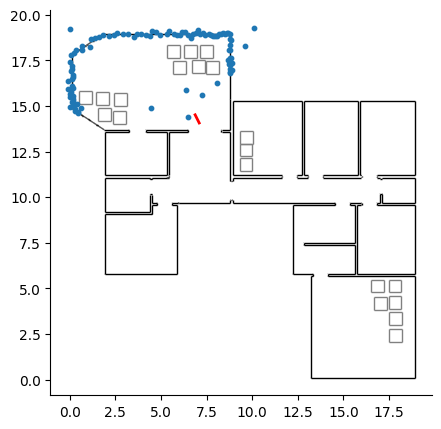

In [33]:
w     = 0
zmax  = 10.0

sensor_model_type = ["constrained", "baseline"][0]
model = make_model(w, zmax, sensor_model_type)
ch = choice_map({
        'x':  jnp.array(_ps[35,:2]), 
        'hd': adjust_angle(_ps[35, 2]),
        'sig':     1e-1,
        'outlier': 0.1,
})
args = (jnp.array([0]),)
key = keysplit(key)
w, tr = model.importance(key, ch, args)

p,X = tr.retval
# ========================================
plot_tr(tr)

In [35]:
def get_data_logprobs(tr):
    """Return individual log-probabilities of each observed pixel value."""
    pixel_addr = lambda i: genjax.select({"X":
        genjax.index_select(i,  genjax.select("measurement"))
    })
    inds  = jnp.arange(tr["X", "measurement"].shape[0])
    logps = vmap(lambda i: tr.project(pixel_addr(i)))(inds)
    return logps

In [36]:
def _eval_pose_and_sensor(tr, key, p, sig, outlier):
    ch = choice_map({
        'x':  p[:2], 
        'hd': adjust_angle(p[2]),
        'sig':     sig,
        'outlier': outlier,
    })
    diffs = argdiffs(tr.args)
    (_, w, tr_, _) = tr.update(key, ch, diffs)
    log_ps = get_data_logprobs(tr_)
    return tr_.get_score(), log_ps


eval_pose_and_sensor = jax.jit(jax.vmap(_eval_pose_and_sensor, in_axes=(None, None, 0, 0, 0)))
eval_pose = jax.jit(jax.vmap(_eval_pose_and_sensor, in_axes=(None, None, 0, None, None)))

## Perturbing the Trace

We create a bunch of traces that could have created in a particle filter update. However we are just perturbing the ground truth pose.

In [37]:
@genjax.gen
def anchored_pose_prior(p, sig_x=0.5, sig_hd=10):
    
    sig_hd = sig_hd/180*jnp.pi

    x  = genjax.tfp_normal(p[:2], sig_x*jnp.ones(2)) @ "x"
    hd = genjax.tfp_normal(p[2], sig_hd)             @ "hd"

    q  = pack_2dpose(x, adjust_angle(hd))
    
    return q

## Create Ground Truth

In [38]:
def make_ground_truth_sampler(w=5, zmax=10.0):

    # Use the constrained model because to 
    # get perturbations along each ray.
    model = make_model(w, zmax, "constrained")

    def sampler(key, p, sig, out, inds):
        args  = (inds,)
        _, tr = model.importance(key, genjax.choice_map({
            "x":  p[:2],
            "hd": adjust_angle(p[2]),
            "sig":     sig, 
            "outlier": out}), args) 
        return tr

    # Jit for optimized performance
    return jit(sampler)

In [39]:
create_ground_truth = make_ground_truth_sampler(w=5, zmax=10.0)

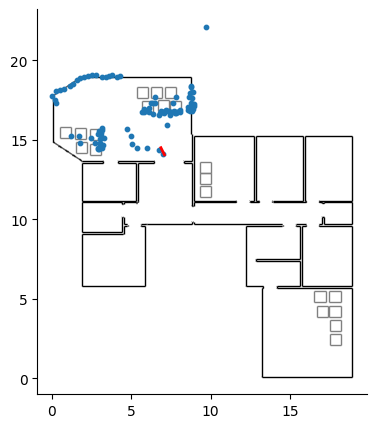

In [42]:
t0   = 35
sig0 = 1e-1
out0 = 0.1
p0   = _ps[t0]

key = keysplit(key)
tr0 = create_ground_truth(key, p0, sig0, out0, jnp.array([0,1]))
plot_tr(tr0)

## Vector Grid

In [46]:
def get_linear_grid(shape, bounds, flat=False):
    
    linspaces = [jnp.linspace(*b, d) for b,d in zip(bounds, shape)]
    vs = jnp.stack(jnp.meshgrid(*linspaces, indexing='ij'), axis=-1)
    if flat: vs = vs.reshape(-1,len(shape))
    
    return vs

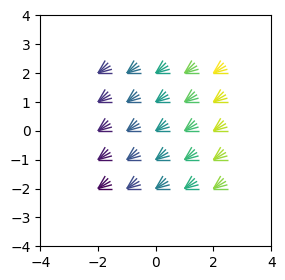

In [47]:
vs = get_linear_grid((5, 5, 5), ((-2,2), (-2,2), (0,jnp.pi/3)), flat=True)
sc = jnp.arange(len(vs))

# =======================================
plt.figure(figsize=(3,3))
zoom_in(vs[:,:2], 2)
plot_poses(vs, sc, linewidth=1)

## Sensor Posterior: $\mathbb{P}(\sigma, \omega \mid p_0, X_0)$

In [50]:
def _eval_sensor(key, tr, inds, sig, out):
    ch = choice_map({'sig': sig, 'outlier': out})
    args = (inds,)
    (_, _, tr_, _) = tr.update(key, ch, argdiffs(args))
    return tr_.get_score()


eval_sensor = jax.jit(jax.vmap(_eval_sensor, in_axes=(None, None, None, 0, 0)))

In [142]:
# TODO: Add coloring to the scatter plot, either by logprob or by outlier.
def sensor_posterior_experiment(key, t0, sig0, out0, use_boxes = True, figsize=(9,3)):

    key = keysplit(key)
    p0  = _ps[t0]
    tr0 = create_ground_truth(key, p0, sig0, out0, jnp.array([0,1]))

    shape = (20,20)
    grid = get_linear_grid(shape, ((0.05, 1.), (1e-2, .9)), flat=False)
    sigs = grid[...,0]
    outs = grid[...,1]

    key    = keysplit(key)
    inds = jnp.array([0,1]) if use_boxes else jnp.array([0])
    scores = eval_sensor(key, tr0, inds, sigs.ravel(), outs.ravel())


    # =================================
    fig, axs = plt.subplots(1,3, figsize=figsize)
    plt.suptitle(f"sig={sig0:0.2f}, out={out0:0.2f}, boxes:{use_boxes}")
    plot_tr(tr0, ax=axs[0], boxes=use_boxes, size=2, c="r")


    axs[1].set_title("$\log \mathbb{P}(\sigma, \omega \mid p_0, X_0)$")
    axs[1].imshow(scores.reshape(grid.shape[:-1]), origin='lower')
    axs[1].set_ylabel("sigma")
    axs[1].set_xlabel("outlier")
    axs[1].set(
        xlabel="$\omega$ - outlier",
        xticks=[0, shape[1]-1], 
        xticklabels=[f"{v:0.2f}" for v in grid[0,[0, shape[1]-1],1]],
        ylabel="$\sigma$ -noise",
        yticks=[0, shape[0]-1], 
        yticklabels=[f"{v:0.4f}" for v in grid[[0, shape[0]-1],0,0]],
    )

    i0 = np.argmin(jnp.abs(grid[:, 0, 0]-sig0)) 
    i1 = np.argmin(jnp.abs(grid[0, :, 1]-out0)) 
    I = jnp.unravel_index(jnp.argmax(scores), shape)
    axs[1].scatter(i1,i0, c="r", marker="^")

    Imax = jnp.unravel_index(jnp.argmax(scores), shape)
    axs[1].scatter(Imax[1],Imax[0], c="b", marker="x")

    axs[2].set_title("$\mathbb{P}(\sigma, \omega \mid p_0, X_0)$")
    im = scores.reshape(grid.shape[:-1])
    im = im - logsumexp(im)
    im = jnp.exp(im)
    axs[2].imshow(im, origin='lower')
    axs[2].set_ylabel("sigma")
    axs[2].set_xlabel("outlier")
    xticks = [0, (shape[1]-1)//2,shape[1]-1]
    axs[2].set(
        xlabel="$\omega$ - outlier",
        xticks=xticks, 
        xticklabels=[f"{v:0.2f}" for v in grid[0,xticks,1]],
        ylabel="$\sigma$ -noise",
        yticks=[0, shape[0]-1], 
        yticklabels=[f"{v:0.4f}" for v in grid[[0, shape[0]-1],0,0]],
    )
    axs[2].scatter(i1,i0, c="r", marker="^")
    # axs[2].scatter(Imax[1],Imax[0], c="b", marker="x")
    fig.tight_layout()

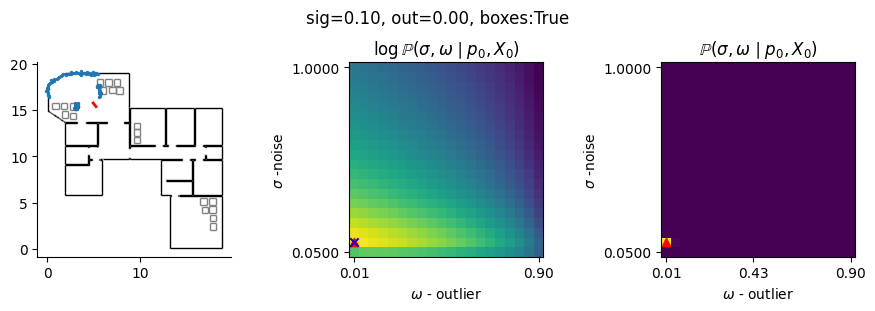

In [143]:
key = keysplit(key)
t0   = 40
sig0 = 0.1
out0 = 0.
use_boxes = True
sensor_posterior_experiment(key, t0, sig0, out0, use_boxes)

### Examples with synthetic data generated by the model itself

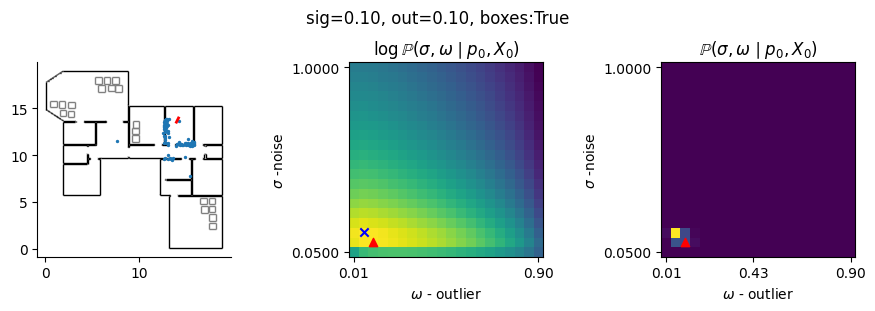

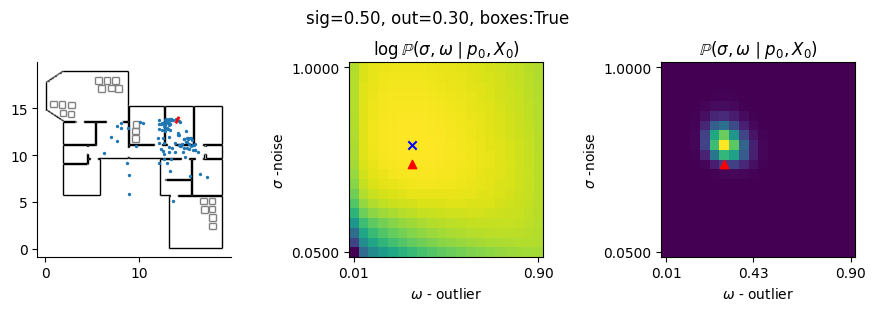

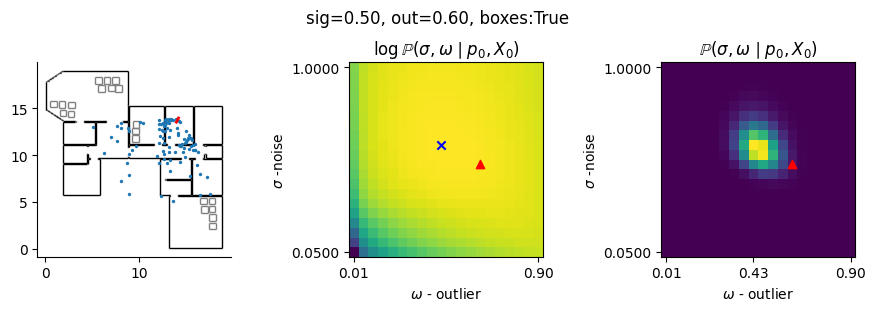

In [146]:
t0 = 4
use_boxes = True
for sig0, out0 in [(0.1,0.1),(0.5,0.3),(0.5,0.6)]:
    sensor_posterior_experiment(key, t0, sig0, out0, use_boxes)

### Examples of data that is NOT generated by the model itself.


inlier vs outlier counts = [44 18], 
outlier_prob             = 0.29



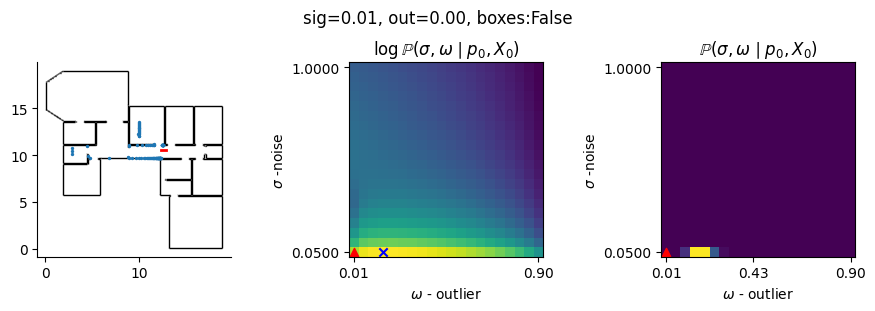

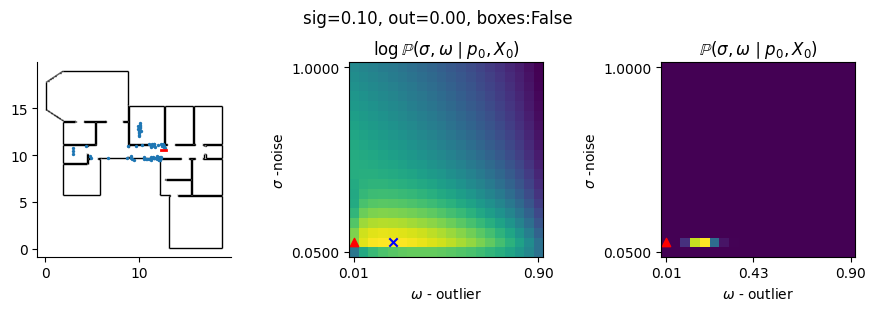

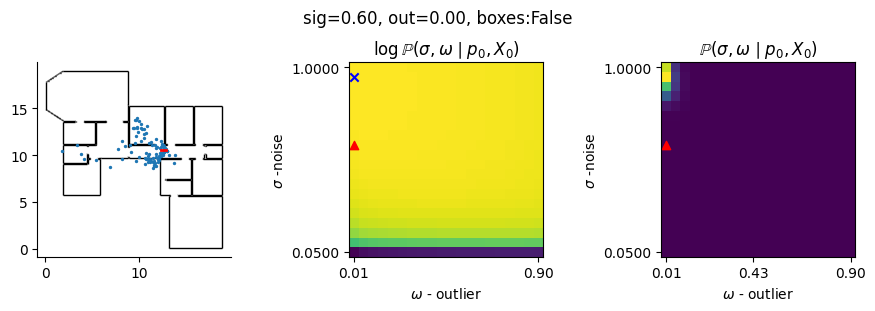

In [160]:
t0 = 15
counts = inlier_vs_outlier_counts(t0)
print(f"""
inlier vs outlier counts = {counts}, 
outlier_prob             = {counts[1]/jnp.sum(counts):0.2f}
""")
out0 = 0.001
use_boxes = False
for sig0 in [1e-2, 1e-1, 0.6]:
    sensor_posterior_experiment(key, t0, sig0, out0, use_boxes)

## Sensor Posterior of perturbed pose:  $\mathbb{P}(\sigma, \omega \mid p, X_0)$
- What changes if we perturb the underlying pose?
- That can inform us if we are lost -> maybe question is that useful? single particle

In [162]:
def perturb_pose(key, tr, sig_x=0.1, sig_hd=5):
    keys = keysplit(key, 3)

    sig_hd = sig_hd/180*jnp.pi
    dx  = genjax.normal(jnp.array([0.0,0.0]), jnp.array([sig_x,sig_x])).sample(keys[0])
    dhd = genjax.normal(0.0, sig_hd).sample(keys[1])

    _,_,tr_,_ = tr.update(keys[2], choice_map({
        "x": tr["x"] + dx,
        "hd": tr["hd"] + dhd
    }), argdiffs(tr.args))
    
    return tr_

In [163]:
# TODO: Add coloring to the scatter plot, either by logprob or by outlier.


def sensor_posterior_experiment_2(key, t0, sigx, sighd, sig0, out0, use_boxes = True, figsize=(9,3)):

    key = keysplit(key)
    p0   = _ps[t0]
    tr0 = create_ground_truth(key, p0, sig0, out0, jnp.array([0,1]))

    # Perturb ground truth
    key = keysplit(key)
    tr0 = perturb_pose(key, tr0, sigx, sighd)

    shape = (20,20)
    grid = get_linear_grid(shape, ((0.05, 1.), (1e-2, .9)), flat=False)


    key    = keysplit(key)
    inds = jnp.array([0,1]) if use_boxes else jnp.array([0])
    scores = eval_sensor(key, tr0, inds, grid[...,0].ravel(), grid[...,1].ravel())

    print(jnp.argmax(scores.reshape(grid.shape[:-1])))
    # =================================
    fig, axs = plt.subplots(1,3, figsize=figsize)

    plt.suptitle(f"sig={sig0:0.2f}, out={out0:0.2f}, boxes:{use_boxes}")
    plot_tr(tr0, ax=axs[0], boxes=use_boxes)
    
    axs[1].set_title("$\log \mathbb{P}(\sigma, \omega \mid p, X_0)$")
    im  = scores.reshape(grid.shape[:-1])
    axs[1].imshow(im, origin='lower')
    axs[1].set_ylabel("sigma")
    axs[1].set_xlabel("outlier")
    axs[1].set(
        xlabel="$\omega$ - outlier",
        xticks=[0, shape[1]-1], 
        xticklabels=[f"{v:0.2f}" for v in grid[0,[0, shape[1]-1],1]],
        ylabel="$\sigma$ -noise",
        yticks=[0, shape[0]-1], 
        yticklabels=[f"{v:0.4f}" for v in grid[[0, shape[0]-1],0,0]],
    )
    i0 = np.argmin(jnp.abs(grid[:, 0, 0]-sig0)) 
    i1 = np.argmin(jnp.abs(grid[0, :, 1]-out0)) 
    I = jnp.unravel_index(jnp.argmax(scores), shape)
    axs[1].scatter(i1,i0, c="r", marker="^")

    I = jnp.unravel_index(jnp.argmax(scores), shape)
    axs[1].scatter(I[1],I[0], c="b", marker="x")
    
    axs[2].set_title("$\mathbb{P}(\sigma, \omega \mid p, X_0)$")
    im = scores.reshape(grid.shape[:-1])
    im = im - logsumexp(im)
    im = jnp.exp(im)
    axs[2].imshow(im, origin='lower')
    axs[2].set_ylabel("sigma")
    axs[2].set_xlabel("outlier")
    axs[2].set(
        xlabel="$\omega$ - outlier",
        xticks=[0, shape[1]-1], 
        xticklabels=[f"{v:0.2f}" for v in grid[0,[0, shape[1]-1],1]],
        ylabel="$\sigma$ -noise",
        yticks=[0, shape[0]-1], 
        yticklabels=[f"{v:0.4f}" for v in grid[[0, shape[0]-1],0,0]],
    )
    fig.tight_layout()

385
391
59
399
248


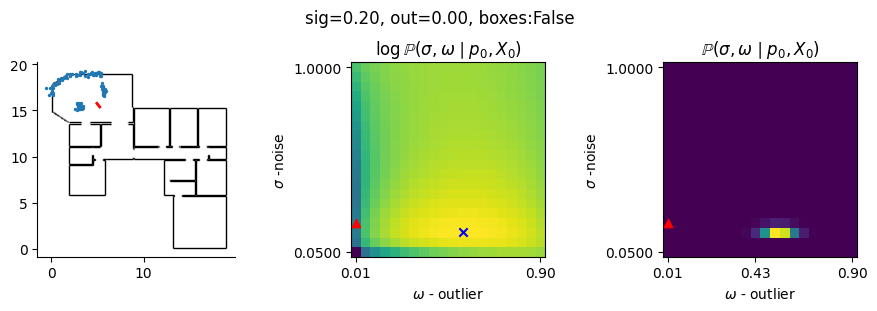

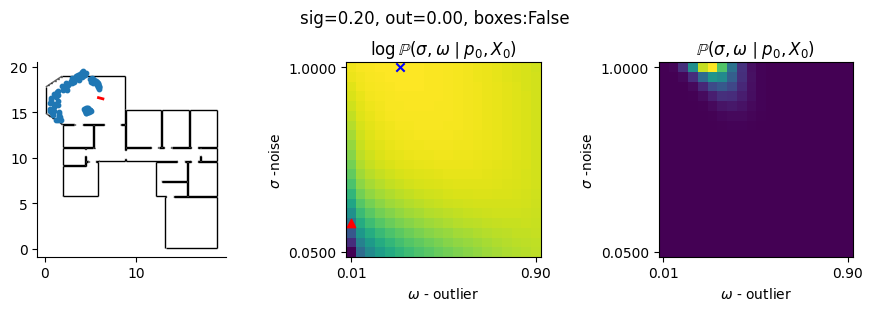

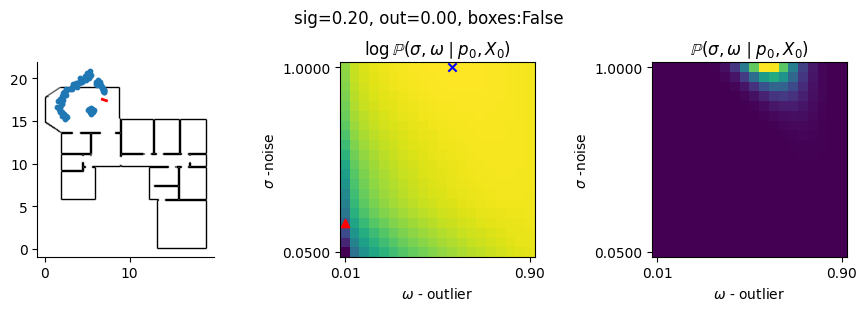

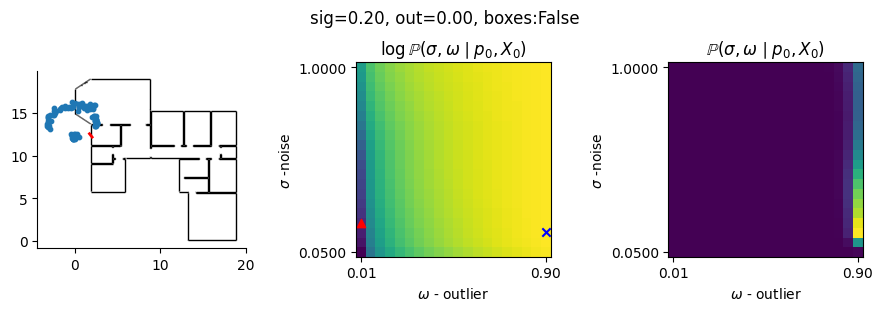

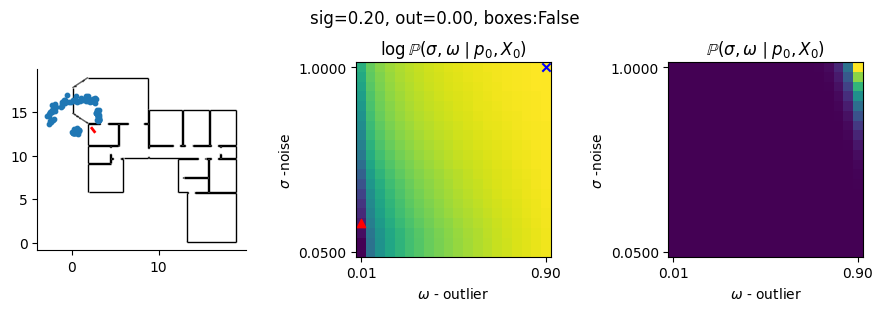

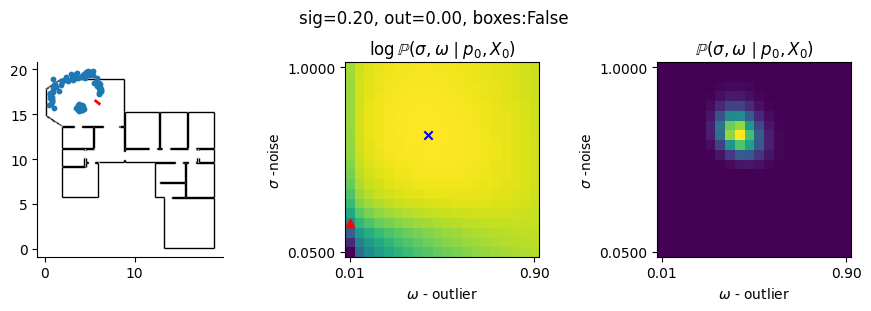

In [164]:
key = keysplit(key)
t0   = 40
sig0 = 0.2
out0 = 0.0
use_boxes = False
sensor_posterior_experiment(key, t0, sig0, out0, use_boxes)

for _ in range(5):
    key = keysplit(key)
    sensor_posterior_experiment_2(key, t0, 3., 20, sig0, out0, use_boxes, figsize=(9,3))

## Pose Posterier: $\mathbb{P}(p \mid \sigma, \omega, X_0)$

In [165]:
# TODO: Convince me that this is actually faster.
@lru_cache(maxsize=None)
def make_inference_trace_sampler(w, zmax, sensor_model_type):
    model = make_model(w, zmax, sensor_model_type)
    importance = jit(model.importance)
    return importance

In [227]:
from timeit import timeit
from ipywidgets import (interact, interactive, IntSlider, FloatSlider, 
        FloatRangeSlider, RadioButtons, Checkbox, Dropdown, Button, VBox, HBox, Output)
import warnings
warnings.filterwarnings('ignore')

button = Button(
                description='Save config',
                disabled=False, button_style='', # 'success', 'info', 'warning', 'danger' or ''
                icon='check' # (FontAwesome names without the `fa-` prefix)
        )


confs = []
vs    = None
sc    = None
shape = None
logps = None
tr0   = None
X0    = None


def func(inference_model_type, t, sig0, out0, regenerate, num_xy, num_hd, xs, ys, hds, sig, out, use_boxes, show_probs, quantile, PAD):

        def on_click(button):
                global confs;
                nonlocal t, sig0, out0, sig, out, use_boxes;
                conf = dict(t=t, sig0=sig0, out0=out0, sig=sig, out=out, use_boxes=use_boxes) 
                confs.append(conf)

        button.on_click(on_click)

        global key, tr0, X0;

        p0  = _ps[t]

        # Regenerate ground truth?
        if regenerate:
                key = keysplit(key)
                tr0 = create_ground_truth(key, p0, sig0, out0, inds=jnp.array([0,1]))
                _, X0  = tr0.get_retval()


        # Preparing a base trace for inference, i.e. one 
        # that we can call update on 
        w, zmax = 5, 10.0
        # %timeit -n 1 -r 1 make_inference_trace_sampler(w, zmax, inference_model_type)

        inference_model_importance = make_inference_trace_sampler(
                w, zmax, inference_model_type)

        inds = jnp.array([0,1]) if use_boxes else jnp.array([0])
        ch            = make_constraints(X0, inference_model_type)
        ch["outlier"] = 0.1

        key = keysplit(key)
        _, tr = inference_model_importance(key, ch, (inds,))


        # Create a vector grid
        shape       = (num_xy, num_xy, num_hd)
        grid_bounds = (xs + p0[0], ys + p0[1], hds + p0[2])
        vs          = get_linear_grid(shape, grid_bounds, flat=False)
        vs_flat     = vs.reshape(-1, len(shape))


        # Evaluate the Grid
        key = keysplit(key)
        # timed = timeit('eval_pose(tr, key, vs_flat[:,:3], sig, out);', globals=globals(), number=1)
        timed = timeit(lambda: eval_pose(tr, key, vs_flat[:,:3], sig, out), globals=globals(), number=1)
        key = keysplit(key)
        sc_flat, logps_flat = eval_pose(tr, key, vs_flat[:,:3], sig, out)
        sc = sc_flat.reshape(shape)
        logps = logps_flat.reshape(shape + (X0.shape[1],))

        ###############################
        ###############################
                

        # =============================
        fig, axs = plt.subplots(1,2, figsize=(15,7))
        plt.suptitle(f"Inference model: {inference_model_type.upper()}")
        plot_tr(tr0, ax=axs[0])
        zoom_in(p0[:2], PAD, ax=axs[0])
        axs[0].set_title("Ground Truth from simulated world")

        plt.subplot(1,2,2)

        axs[1].text(0.05, 0.95, f"Num evals: {np.prod(shape)}\nGrid evaluation: {timed*1_000:4.2f} ms ", transform=axs[1].transAxes, fontsize=11,
                        verticalalignment='top', 
                        bbox=dict(facecolor='w', alpha=1.))

        axs[1].set_title("Inference in modelled world")
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['right'].set_visible(False)
        zoom_in(p0[:2], PAD)
        plot_segs(_segs, c="k", zorder=1)
        if use_boxes: plot_segs(_boxes, c="k", zorder=1)

        sc_ = sc - logsumexp(sc)
        if show_probs: 
                plot_poses(vs, jnp.exp(sc_), r=0.5, q=quantile, clip=-1e12)
        else:
                plot_poses(vs, sc_, r=0.5, q=quantile, clip=-1e12)

        plot_pose(p0, r=0.3, linewidth=2)
        fig.show()


widget = interactive(func,
        inference_model_type = Dropdown(options=["constrained", "baseline"],value="constrained",description='Inference model:',disabled=False),
        t = IntSlider(min=0, max=_T-1, step=1, value=35, continuous_update=False, description="t:"),
        sig0 = FloatSlider(min=1e-6, max=1., step=0.01, value=1e-6, continuous_update=False),
        out0 = FloatSlider(min=0.0, max=1., step=0.01, value=0.0, continuous_update=False),
        regenerate  = Checkbox(value=True, description='Regenerate:',disabled=False),
        num_xy  = IntSlider(min=0, max=30, step=1, value=5, continuous_update=False),
        num_hd  = IntSlider(min=0, max=30, step=1, value=5, continuous_update=False),
        xs   = FloatRangeSlider(min=-8.0, max=8.0, step=0.01, value=[-1.0,1.0], readout_format='.1f', continuous_update=False),
        ys   = FloatRangeSlider(min=-8.0, max=8.0, step=0.01, value=[-1.0,1.0], readout_format='.1f', continuous_update=False),
        hds  = FloatRangeSlider(min=-jnp.pi, max=jnp.pi, step=0.01, value=[-jnp.pi/4,jnp.pi/4], readout_format='.1f', continuous_update=False),
        sig  = FloatSlider(min=0.05, max=1., step=0.01, value=0.1, continuous_update=False),
        out  = FloatSlider(min=0.0, max=1., step=0.01, value=0.1, continuous_update=False),
        use_boxes  = Checkbox(value=True,description='Use Boxes:',disabled=False),
        show_probs = Checkbox(value=False, description='Probability',disabled=False),
        quantile = FloatSlider(min=0.0, max=1., step=0.01, value=0.0, continuous_update=False),
        PAD = FloatSlider(min=0.0, max=15., step=0.01, value=8.0, continuous_update=False),
)

display(VBox([
       button, *widget.children[:-1], widget.children[-1]
]))

## Full posterior: $\mathbb{P}(p, \sigma, \omega \mid X_0)$

In [233]:
def pose_error(p, q):
    d = p - q
    d = d.at[2].set(adjust_angle(d[2]))
    return jnp.linalg.norm(d)

In [264]:
from timeit import timeit
from ipywidgets import (interact, interactive, IntSlider, FloatSlider, 
        FloatRangeSlider, RadioButtons, Checkbox, Dropdown, Button, VBox, HBox, Output)
import warnings
warnings.filterwarnings('ignore')

button = Button(
                description='Save config',
                disabled=False, button_style='', # 'success', 'info', 'warning', 'danger' or ''
                icon='check' # (FontAwesome names without the `fa-` prefix)
        )


confs = []
vs    = None
sc    = None
shape = None
logps = None
tr0   = None
X0    = None


def func(inference_model_type, t, sig0, out0, regenerate, num_xy, num_hd, num_sig, num_out, xs, ys, hds, sigs, outs, use_boxes, show_probs, quantile, PAD):

        global key, tr0, X0;

        p0  = _ps[t]

        # Regenerate ground truth?
        if regenerate:
                key = keysplit(key)
                tr0 = create_ground_truth(key, p0, sig0, out0, inds=jnp.array([0,1]))
                _, X0  = tr0.get_retval()


        # Preparing a base trace for inference, i.e. one 
        # that we can call update on 
        w, zmax = 5, 10.0
        # %timeit -n 1 -r 1 make_inference_trace_sampler(w, zmax, inference_model_type)

        inference_model_importance = make_inference_trace_sampler(
                w, zmax, inference_model_type)

        inds = jnp.array([0,1]) if use_boxes else jnp.array([0])
        ch            = make_constraints(X0, inference_model_type)
        ch["outlier"] = 0.1

        key = keysplit(key)
        _, tr = inference_model_importance(key, ch, (inds,))


        # Create a vector grid
        shape       = (num_xy, num_xy, num_hd, num_sig, num_out)
        grid_bounds = (xs + p0[0], ys + p0[1], hds + p0[2], sigs, outs)
        vs          = get_linear_grid(shape, grid_bounds, flat=False)
        vs_flat     = vs.reshape(-1, len(shape))


        # Evaluate the Grid
        key = keysplit(key)
        timed = timeit(lambda: eval_pose_and_sensor(tr, key, vs_flat[:,:3], vs_flat[:,3], vs_flat[:,4]), globals=globals(), number=1)
        key = keysplit(key)
        sc_flat, logps_flat = eval_pose_and_sensor(tr, key, vs_flat[:,:3], vs_flat[:,3], vs_flat[:,4])
        sc = sc_flat.reshape(shape)
        logps = logps_flat.reshape(shape + (X0.shape[1],))

        ###############################
        ###############################
                
        sensor_marginal = logsumexp(sc, axis=(0,1,2))
        sensor_marginal = sensor_marginal - logsumexp(sensor_marginal)


        pose_marginal = logsumexp(sc, axis=(3,4))
        pose_marginal = pose_marginal - logsumexp(pose_marginal)


        # =============================
        fig, axs = plt.subplots(2,3, figsize=(15,7), height_ratios=[1,10], width_ratios=[5,5,2])
        plt.suptitle(f"Inference model: {inference_model_type.upper()}")

        # --------------------
        for ax in axs[0,:]: ax.axis("off")

        # --------------------
        ax = axs[0,1]
        ax.text(0.05, 0.95, f"Num evals: {np.prod(shape)}\nGrid evaluation: {timed*1_000:4.2f} ms ", transform=ax.transAxes, fontsize=11,
                        verticalalignment='top', 
                        bbox=dict(facecolor='w', alpha=1.))

        # --------------------
        ax = axs[1,0]
        plot_tr(tr0, ax=ax)
        zoom_in(p0[:2], PAD, ax=ax)
        ax.set_title("Ground Truth from simulated world")

        # --------------------
        ax = axs[1,2]
        if show_probs: ax.set_title("$\mathbb{P}(\sigma, \omega \mid X_0)$")
        else: ax.set_title("$\log \mathbb{P}(\sigma, \omega \mid X_0)$")
        

        ax.set(
                xlabel="outlier",
                xticks=[0, shape[4]-1], 
                xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
                ylabel="noise",
                yticks=[0, shape[3]-1], 
                yticklabels=[f"{v:0.4f}" for v in vs[0,0,0,[0, shape[3]-1],0,3]],
        )

        if show_probs: 
                ax.imshow(jnp.exp(sensor_marginal), origin="lower")
        else:
                ax.imshow(sensor_marginal, origin="lower")

        # --------------------
        ax = axs[1,1]
        if show_probs: ax.set_title("$\mathbb{P}(p \mid X_0)$")
        else: ax.set_title("$\log \mathbb{P}(p \mid X_0)$")
        ax.set_aspect(1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        zoom_in(p0[:2], PAD, ax=ax)
        plot_segs(_segs, c="k", zorder=1, ax=ax)
        if use_boxes: plot_segs(_boxes, c="k", zorder=1, ax=ax)

        if show_probs: 
                plot_poses(vs[:,:,:,0,0,:3], jnp.exp(pose_marginal), r=0.5, q=quantile, clip=-1e12, ax=ax)
        else:
                plot_poses(vs[:,:,:,0,0,:3], pose_marginal, r=0.5, q=quantile, clip=-1e12, ax=ax)

        fig.tight_layout()



widget = interactive(func,
        inference_model_type = Dropdown(options=["constrained", "baseline"],value="constrained",description='Inference model:',disabled=False),
        t = IntSlider(min=0, max=_T-1, step=1, value=35, continuous_update=False, description="t:"),
        sig0 = FloatSlider(min=1e-6, max=1., step=0.01, value=1e-6, continuous_update=False),
        out0 = FloatSlider(min=0.0, max=1., step=0.01, value=0.0, continuous_update=False),
        regenerate  = Checkbox(value=True, description='Regenerate:',disabled=False),
        num_xy  = IntSlider(min=0, max=10, step=1, value=5, continuous_update=False),
        num_hd  = IntSlider(min=0, max=10, step=1, value=5, continuous_update=False),
        num_sig = IntSlider(min=0, max=10, step=1, value=5, continuous_update=False),
        num_out = IntSlider(min=0, max=10, step=1, value=5, continuous_update=False),
        xs   = FloatRangeSlider(min=-3.0, max=3.0, step=0.01, value=[-1.0,1.0], readout_format='.1f', continuous_update=False),
        ys   = FloatRangeSlider(min=-3.0, max=3.0, step=0.01, value=[-1.0,1.0], readout_format='.1f', continuous_update=False),
        hds  = FloatRangeSlider(min=-jnp.pi, max=jnp.pi, step=0.01, value=[-jnp.pi/4,jnp.pi/4], readout_format='.1f', continuous_update=False),
        sigs = FloatRangeSlider(min=1e-6, max=1.0, step=0.01, value=[0.01,0.7], readout_format='.1f', continuous_update=False),
        outs = FloatRangeSlider(min=0.0,  max=1.0, step=0.01, value=[0.01,0.9], readout_format='.1f', continuous_update=False),
        use_boxes  = Checkbox(value=True,description='Use Boxes:',disabled=False),
        show_probs = Checkbox(value=False, description='Probability',disabled=False),
        quantile = FloatSlider(min=0.0, max=1., step=0.01, value=0.0, continuous_update=False),
        PAD = FloatSlider(min=0.0, max=15., step=0.01, value=8.0, continuous_update=False),
)

display(VBox([
       button, *widget.children[:-1], widget.children[-1]
]))

## Experiment

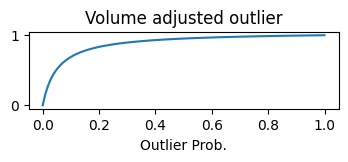

In [229]:
w     = 5
zmax  = 20.
vol   = 1
out   = .2

# This is relevant to map between Nishad's version and mine.
def volume_adjust(out, zmax, vol):
    """Gives w' such that we have (1-w)p + w/zmax = (1-w')p + w'/vol."""
    return (out*zmax/vol)/(1- out + out*zmax/vol)


# -------------
outls = jnp.linspace(0,1,100)
plt.figure(figsize=(4,1))
plt.title("Volume adjusted outlier")
plt.plot(outls, vmap(partial(volume_adjust, zmax=zmax, vol=vol))(outls))
plt.xlabel("Outlier Prob.")

In [232]:
t0 = 35
exp_id = 2

ps = jnp.load(f"data/hierarchical_bayes_#1_t{t0}_ps.npy")
trs = vmap(lambda tr,p: tr.update(
                    key, 
                    choice_map({"x": p[:2], "hd": p[2]}), 
                    argdiffs(args))[2])(trs, ps)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_3511/2961021157.py:8 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_3511/2961021157.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'trs' is not defined

In [85]:
# Plot function for grid summary
i = 0
tr = trs.slice(i)

dx  = 1.
dhd = 35/180*jnp.pi
shape = (5,5,5, 5,5)
VOL = zmax

# Grid
vs = make_inference_grid(tr, shape, 
                dx, dhd,  
                sig     = (0.1, 0.7), 
                outlier = (0.0, 0.9))
vs_flat = vs.reshape(-1, len(shape))

# Eval Grid
key   = keysplit(key)
outls = vmap(volume_adjust, (0,None, None))(vs_flat[:,4], zmax, VOL)

sc_flat, logps = eval_pose_and_sensor(tr, key, vs_flat[:,:3], vs_flat[:,3], outls)

sc    = sc_flat.reshape(shape)
logps = logps.reshape(shape + (tr["X", "measurement"].shape[0],))



def plot_grid_summary(vs, sc, shape):

    vs_flat = vs.reshape(-1, len(shape))
    sc_flat = sc.reshape(-1)


    # Marginalize out poses
    sc_marg  = logsumexp(sc, axis=(0,1,2))
    sc_marg  = sc_marg - logsumexp(sc_marg)
    sc_marg_ = jnp.clip(sc_marg, jnp.quantile(sc_marg, 0.25), jnp.max(sc_marg))

    # Expected Pose Error
    err_flat = vmap(partial(pose_error, p0))(vs.reshape(-1,len(shape))[:,:3])
    err      = err_flat.reshape(shape)
    pr       = jnp.exp(sc - logsumexp(sc, axis=(0,1,2)))
    mean_err = jnp.sum(pr*err, axis=(0,1,2))

    # =================================================
    fig, axs = plt.subplots(1,4,figsize=(12,4))
    plt.suptitle(f"Grid summary\nfor {sensor_model_type.upper()} model")
    axs[0].set_title("Marg. over $p$\n$\log \mathbb{P}(\sigma, \omega \mid X)$")
    axs[0].imshow(sc_marg_, origin='lower')
    axs[0].set_xticklabels(vs[0,0,0,0,:1,4])
    axs[0].set(
        xlabel="outlier",
        xticks=[0, shape[4]-1], 
        xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
        ylabel="noise",
        yticks=[0, shape[3]-1], 
        yticklabels=[f"{v:0.4f}" for v in vs[0,0,0,[0, shape[3]-1],0,3]],
    )

    axs[1].set_title("Marg. over $p$\n$\mathbb{P}(\sigma, \omega \mid X)$")
    axs[1].imshow(jnp.exp(sc_marg), vmin=0.0, origin='lower')
    axs[1].set(
        xlabel="outlier",
        xticks=[0, shape[4]-1], 
        xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
        yticks=[],
    )

    axs[2].set_title("Exp. Pose Error\n$\mathbb{E}_{\mathbb{P}(p \mid \sigma, \omega)} ( err(p) )$")
    axs[2].imshow(mean_err, vmin=jnp.min(err), vmax=jnp.max(err), cmap="viridis", origin='lower')
    axs[2].set(
        xlabel="outlier",
        xticks=[0, shape[4]-1], 
        xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
        yticks=[],
    );


    plt.subplot(1,4,4)
    ax = plt.gca()
    ax.set_title("Marg. over $\sigma, \omega$\n$\log \mathbb{P}(p \mid X)$")
    vs_ = vs[:,:,:,0,0].reshape(-1,len(shape))
    sc_ = logsumexp(sc, axis=(3,4)).reshape(-1)
    PAD = 4; 
    zoom_in(p0[:2], PAD)
    plot_segs(_segs, c="k", zorder=1)
    plot_segs(_boxes, c="lightgray", zorder=1)
    plot_poses(vs_[:,:3], sc_.reshape(-1), r=0.5, q=0.3)
    plot_pose(p0, r=0.3, linewidth=2)
    
    fig.tight_layout()


plot_grid_summary(vs, sc, shape)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_9465/2744059728.py:3 in <module>                                                  │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_9465/2744059728.py'                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'trs' is not defined

**Notation:**
- $p=(x, \theta)$ &mdash; Pose
- $\sigma$ &mdash; Sensor noise
- $\omega$ &mdash; Outlier probability

**Marginal Probability:**

We define $\mathbb{P}(p, \sigma, \omega \mid X) \propto \textup{e}^{\text{sc}(p, \sigma, \omega \mid X)}$ and integrate out the hyper parameters to get the marginal
$$
    \mathbb{P}(\sigma, \omega \mid X)  = \int_{\sigma, \omega} \mathbb{P}(p, \sigma, \omega \mid X) \ d\sigma d\omega
$$ 

**Expected pose error:**

We define the error $\text{err}(p) = \text{err}(p, p_0)$ of a pose $p$ as its Euclidean distance to the ground truth $p_0$, i.e. $\text{err}(p) = \| p - p_0 \|$  &mdash; here we identify the head direction with an element in $\mathbb{R}/2\pi\mathbb{R}$ and use its induced norm. The expected pose error $\text{err}(\sigma, \omega)$ for a given pair $(\sigma,\omega)$ is given by
$$
    \text{err}(\sigma, \omega) := \mathbb{E}_{\ p \ \sim \ \mathbb{P}( . \mid \sigma, \omega; X )}\big[ \text{err}(p)   \big].
$$

**How to read and parse the figure:**

- **Subfigures 1-3:** The probability mass of the marginal $\mathbb{P}(\sigma, \omega \mid X)$ should be concentrated in low error regions of $\text{err}(\sigma, \omega)$.
- **Subfigure 4:** The probability mass of the marginal $\mathbb{P}(p \mid X)$ should be close to the ground truth pose $p_0$ plotted in red.

In [37]:
from ipywidgets import interact, IntSlider, FloatSlider, FloatRangeSlider


vs = None
sc = None
shape = None
logps = None
@interact(
        i = IntSlider(min=0, max=N-1, step=1, value=0, continuous_update=False, description="trace:"),
        num_x   = IntSlider(min=0, max=15, step=1, value=5, continuous_update=False),
        num_hd  = IntSlider(min=0, max=15, step=1, value=5, continuous_update=False),
        num_sig = IntSlider(min=0, max=15, step=1, value=5, continuous_update=False),
        num_out = IntSlider(min=0, max=15, step=1, value=5, continuous_update=False),
        sig = FloatRangeSlider(min=1e-6, max=1.0, step=0.01, value=[0.05,0.7], continuous_update=False),
        out = FloatRangeSlider(min=0, max=1.0, step=0.01, value=[0.0,0.7], continuous_update=False),
        VOL = FloatSlider(min=0.001, max=150., step=0.01, value=zmax, continuous_update=False),
)
def func(i, num_x, num_hd, num_sig, num_out, sig, out, VOL):
        
        global key;
        global vs, sc, shape, logps;
        
        tr = trs.slice(i)

        # Grid config
        dx  = 1.
        dhd = 35/180*jnp.pi
        shape = (num_x, num_x, num_hd, num_sig, num_out)

        # Grid
        vs = make_inference_grid(tr, shape, dx, dhd, sig = sig, outlier = out)
        vs_flat  = vs.reshape(-1, len(shape))
        
        # Eval Grid
        key = keysplit(key)
        outls = vmap(volume_adjust, (0,None, None))(vs_flat[:,4], zmax, VOL)
        sc_flat, logps = eval_pose_and_sensor(tr, key, vs_flat[:,:3], vs_flat[:,3], outls)
        sc = sc_flat.reshape(shape)
        logps = logps.reshape(shape + (tr["X", "measurement"].shape[0],))

        # Plot summary
        plot_grid_summary(vs, sc, shape)

interactive(children=(IntSlider(value=0, continuous_update=False, description='trace:', max=19), IntSlider(val…

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import (interact, interactive, FloatSlider, IntSlider, 
        Button, Output, HBox, VBox, FloatRangeSlider, Layout, Checkbox, RadioButtons)
from ipywidgets.embed import embed_minimal_html

def func(i, j, k0, k1, sorted_by):


        global key;
        global vs, sc, shape, logps;
        
        vs_flat = vs.reshape(-1, len(shape))
        sc_flat = sc.reshape(-1)

        # Marginalize out poses
        sc_marg  = logsumexp(sc, axis=(0,1,2))
        sc_marg  = sc_marg - logsumexp(sc_marg)
        sc_marg_ = jnp.clip(sc_marg, jnp.quantile(sc_marg, 0.5), jnp.max(sc_marg))

        # Expected Pose Error
        err_flat = vmap(partial(pose_error, p0))(vs.reshape(-1,len(shape))[:,:3])
        err      = err_flat.reshape(shape)
        pr       = jnp.exp(sc - logsumexp(sc, axis=(0,1,2)))
        mean_err = jnp.sum(pr*err, axis=(0,1,2))

        
        vs_    =    vs[:,:,:,i,j].reshape(-1,len(shape))
        sc_    =    sc[:,:,:,i,j].reshape(-1)
        logps_ = logps[:,:,:,i,j].reshape(-1, logps.shape[-1])
        err_   =   err[:,:,:,i,j].reshape(-1)
        
        order0 = jnp.argsort(sc_)[::-1]
        order1 = jnp.argsort(err_)
        k = k0 if sorted_by=="score" else k1
        order = order0 if sorted_by=="score" else order1

        is_outlier = jnp.exp(logps_[order[k]]) < 2*vs_[order[k],4]/zmax


        a = vs_[:,:2]
        b = a + 0.4 * jax.vmap(unit_vec)(vs_[:,2])

        center = (vs_[0,:2] + vs_[-1,:2])/2
        sc_ = jnp.clip(sc_, jnp.quantile(sc_, 0.6), jnp.max(sc_))
        cs = plt.cm.viridis(plt.Normalize()(sc_))

        # =====================================
        fig, axs = plt.subplots(2, 4, figsize=(12,12), 
                width_ratios  = [1, 1, 1, 1], 
                height_ratios = [1, 3],
        )
        
        plt.suptitle(f"Grid summary\nfor {sensor_model_type.upper()} model")

        ######
        ######
        ax = axs[0,0]
        ax.set_title("$\log \mathbb{P}(\sigma, \omega \mid X)$")
        ax.imshow(sc_marg_, origin='lower')
        ax.set_xticklabels(vs[0,0,0,0,:1,4])
        ax.set(
                xlabel="outlier",
                xticks=[0, shape[4]-1], 
                xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
                ylabel="noise",
                yticks=[0, shape[3]-1], 
                yticklabels=[f"{v:0.4f}" for v in vs[0,0,0,[0, shape[3]-1],0,3]],
        )
        ax.scatter(j,i,c="red")


        ######
        ######
        ax = axs[0,1] 
        ax.set_title("$\mathbb{E}_{\mathbb{P}(p \mid \sigma, \omega)} ( err(p) )$")
        ax.imshow(mean_err, vmin=jnp.min(err), vmax=jnp.max(err), cmap="viridis", origin='lower')
        ax.set(
                xlabel="outlier",
                xticks=[0, shape[4]-1], 
                xticklabels=[f"{v:0.2f}" for v in vs[0,0,0,0,[0, shape[4]-1],4]],
                yticks=[],
        );
        ax.scatter(j,i,c="red");


        ######
        ######
        gs = axs[0, 2].get_gridspec()
        axs[0,2].remove()
        axs[0,3].remove()
        ax = fig.add_subplot(gs[0,2:])
        ax.set_title("Pixel Probs")
        
        ax.plot(jnp.exp(logps_[order[k]]), marker="o")
        ax.set(
                xlabel="Pixel",
                ylim=(-0.1,jnp.max(jnp.exp(logps_[order[k]]))+0.2)
        );


        ######
        ######
        gs = axs[1, 0].get_gridspec()
        axs[1,0].remove()
        axs[1,1].remove()
        ax = fig.add_subplot(gs[1,:2])
        ax.set_title("Pose scores and outliers")
        ax.set_aspect(1)
        plot_segs(_segs, c="k", zorder=1)
        plot_segs(_boxes, c="lightgray", zorder=1)
        zoom_in(center, 7)
        ax.plot(*jnp.stack([p0[:2], p0[:2] + 0.2*unit_vec(p0[2])], axis=1), 
                c="r", zorder=4, linewidth=2)

        ax.add_collection(line_collection(a[order0[::-1]],b[order0[::-1]], c=cs[order0[::-1]], zorder=1, linewidth=3));

        o_ = jnp.argsort(logps_[order[k]])
        # ax.scatter(*apply_2dpose(vs_[order[k],:3], xs[o_]).T, s=100, c=jnp.exp(logps_[order[k]][o_]))
        ax.scatter(*apply_2dpose(vs_[order[k],:3], xs[is_outlier==False]).T, s=60, c="blue")
        ax.scatter(*apply_2dpose(vs_[order[k],:3], xs[is_outlier==True]).T, s=40, c="red")


        ######
        ######
        gs = axs[1, 2].get_gridspec()
        axs[1,2].remove()
        axs[1,3].remove()
        ax = fig.add_subplot(gs[1,2:])
        ax.set_title("Inferred pose and pixel probs")
        ax.set_aspect(1)
        plot_segs(_segs, c="k", zorder=1)
        plot_segs(_boxes, c="lightgray", zorder=1)
        zoom_in(center, 7)
        ax.add_collection(line_collection(a[order0[::-1]],b[order0[::-1]], c="lightgray", zorder=1, linewidth=1));
        plot_pose(p0, r=0.3, c="r", zorder=3)
        plot_pose(vs_[order[k],:3], r=0.3, c="b", zorder=4)
        ax.scatter(*apply_2dpose(vs_[order[k],:3], xs[o_]).T, s=40, c=jnp.exp(logps_[order[k]][o_]), cmap="plasma")


        ######
        ######
        fig.tight_layout()



w = interactive(func, 
    i = IntSlider(min=0, max=shape[3]-1, step=1, value=0, continuous_update=False, description='sig:'),
    j = IntSlider(min=0, max=shape[4]-1, step=1, value=0, continuous_update=False, description='out:'),
    k0 = IntSlider(min=0, max=np.prod(shape[:3])-1, step=1, value=0, continuous_update=False, description='i score:'),
    k1 = IntSlider(min=0, max=np.prod(shape[:3])-1, step=1, value=0, continuous_update=False, description='i err:'),
    sorted_by = RadioButtons(options=['score', 'err'],value='score', description='Sorted by:',disabled=False)
);


w

interactive(children=(IntSlider(value=0, continuous_update=False, description='sig:', max=4), IntSlider(value=…

In [ ]:
import json


exp_id = 0
ps = jnp.concatenate([trs["x"], trs["hd"][:,None]], axis=-1)
jnp.save(f"data/hierarchical_bayes_#{exp_id}_t{t0}_ps", ps)
fname = f"data/hierarchical_bayes_#{exp_id}.json"
with open(fname, "w") as f:
    f.write(json.dumps(dict(t0= t0,ps = np.array(ps).tolist())))